<a href="https://colab.research.google.com/github/Militensire/Kohinoka_Project/blob/main/coffe_leave_disease_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b>Preparation<b>

## <i>Import Library Dependencies<i>

In [ ]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

#from tqdm import tqdm

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.4.1
• Using TensorFlow Hub Version:  0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
• GPU Device Found.


In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tqdm import tqdm
import numpy as np
from glob import glob

## <i>Mount Drive to Input Dataset<i>

Mount the drive which contain coffe leave rust and miner dataset.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/kohinoka/coffe_leave_disease.zip"

## <i>Save the dataset to Colab<i>

Unzip the the dataset and save it under '/tmp' directory. /tmp folder can be seen at the file section on the left window. 

In [ ]:
import os
import zipfile

local_zip = '/content/drive/My Drive/kohinoka/coffe_leave_disease_filtered - Copy.zip'
# local_zip = '/content/drive/My Drive/kohinoka/coffe_leave_disease_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

define the train and validation folder path using OS library

In [ ]:
base_dir = '/tmp/coffe_leave_disease_filtered - Copy'
# base_dir = '/tmp/coffe_leave_disease_filtered'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training miner/rust pictures
train_miner_dir = os.path.join(train_dir, 'miner')
train_rust_dir = os.path.join(train_dir, 'rust')

# Directory with our validation miner/rust pictures
# test_miner_dir = os.path.join(test_dir, 'miner')
# test_rust_dir = os.path.join(test_dir, 'rust')

## <i>Cheking the Dataset<i>

Several codes below could help you to see some parts of the dataset

In [ ]:
train_miner_fnames = os.listdir( train_miner_dir )
train_rust_fnames = os.listdir( train_rust_dir )

print(train_miner_fnames[:10])
print(train_rust_fnames[:10])

['bicho_mineiro101.jpg', 'bicho_mineiro228.jpg', 'bicho_mineiro45.jpg', 'bicho_mineiro180.jpg', 'bicho_mineiro100.jpg', 'bicho_mineiro125.jpg', 'bicho_mineiro163.jpg', 'bicho_mineiro108.jpg', 'bicho_mineiro222.jpg', 'bicho_mineiro93.jpg']
['name127.jpg', 'name67.jpg', 'name245.jpg', 'name246.jpg', 'name263.jpg', 'name228.jpg', 'name233.jpg', 'name173.jpg', 'name75.jpg', 'name286.jpg']


In [ ]:
print('total training miner images :', len(os.listdir(train_miner_dir ) ))
print('total training rust images :', len(os.listdir(train_rust_dir ) ))

print('total test miner images :', len(os.listdir( test_dir ) ))
# print('total validation rust images :', len(os.listdir( validation_rust_dir ) ))

total training miner images : 229
total training rust images : 256
total test miner images : 1


In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

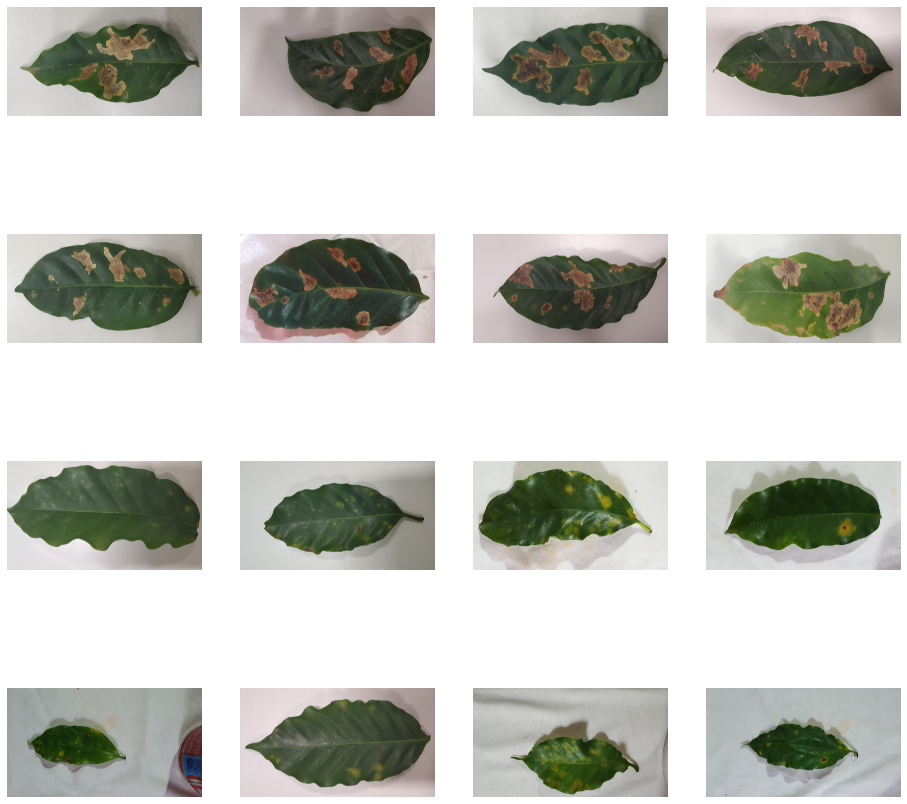

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_miner_pix = [os.path.join(train_miner_dir, fname) 
                for fname in train_miner_fnames[ pic_index-8:pic_index] 
               ]

next_rust_pix = [os.path.join(train_rust_dir, fname) 
                for fname in train_rust_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_miner_pix+next_rust_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


# <b>Inception_V3 Model<b>

## <i>Model Preparation<i>

*   Load the TensorFlow Hub Feature Vector. Select which model will be used.



In [ ]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE])

print("Using {} with input size {} and output dimension {}".format(handle_base, IMAGE_SIZE, FV_SIZE))

Using inception_v3 with input size (299, 299) and output dimension 2048


* Select if you want to do fine tuning

In [ ]:
do_fine_tuning = False #@param {type:"boolean"}

if do_fine_tuning:
    feature_extractor.trainable = True    
else:
    feature_extractor.trainable = False

* Build the model

In [ ]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


* Configure the model metrics

In [ ]:
if do_fine_tuning:
    optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9)
else:
    optimizer = 'adam'
    # optimizer = 'rmsprop'
    
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## <i>Generate Train and Test Image<i>

* Generate Dataset for training, validation, and testing

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size = 23

train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size= IMAGE_SIZE,  # All images will be resized to 150x150
        batch_size=batch_size,
        color_mode = 'rgb',
        subset='training',
        shuffle=True,
        class_mode='sparse')

valid_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size= IMAGE_SIZE,  # All images will be resized to 150x150
        batch_size=batch_size,
        color_mode = 'rgb',
        subset='validation',
        shuffle=True,
        class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size= IMAGE_SIZE,
        color_mode="rgb",
        batch_size=1,
        class_mode=None,
        shuffle=False)


Found 389 images belonging to 2 classes.
Found 96 images belonging to 2 classes.
Found 57 images belonging to 1 classes.


In [ ]:
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='sparse_categorical_crossentropy', factor=0.2, patience=3, min_lr=0.0001
# )
# early = tf.keras.callbacks.EarlyStopping(
#     monitor='sparse_categorical_crossentropy', patience=6, mode='auto'
# )

history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.n//train_generator.batch_size,
      epochs=5,
      validation_data=train_generator,
      validation_steps=valid_generator.n//valid_generator.batch_size,
      verbose=1,
      # callbacks=[reduce_lr,early]
      )

Epoch 1/5
16/16 [==============================] - 120s 5s/step - loss: 0.6598 - accuracy: 0.6020 - val_loss: 0.2865 - val_accuracy: 0.9130
Epoch 2/5
16/16 [==============================] - 81s 5s/step - loss: 0.2593 - accuracy: 0.9388 - val_loss: 0.2002 - val_accuracy: 0.9348
Epoch 3/5
16/16 [==============================] - 81s 5s/step - loss: 0.1263 - accuracy: 0.9747 - val_loss: 0.1222 - val_accuracy: 0.9674
Epoch 4/5
16/16 [==============================] - 81s 5s/step - loss: 0.1031 - accuracy: 0.9830 - val_loss: 0.1144 - val_accuracy: 0.9674
Epoch 5/5
16/16 [==============================] - 81s 5s/step - loss: 0.1001 - accuracy: 0.9813 - val_loss: 0.0563 - val_accuracy: 0.9891


## <i>Plotting Loss and Accuracy<i>

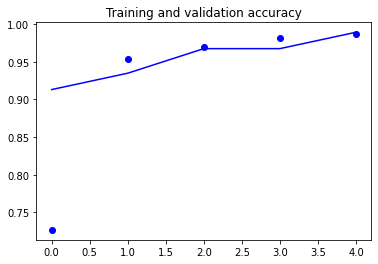

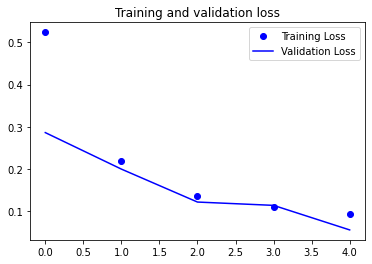

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## <i>Testing the Model<i>

<i> Evaluate loss and accuracy of the model<i>

In [ ]:
score = model.evaluate(valid_generator)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

5/5 [==============================] - 17s 3s/step - loss: 0.1161 - accuracy: 0.9896


<i> Passing test_generator to the model<i>

In [ ]:
pred = model.predict(test_generator) 
pred = np.argmax(pred, axis = 1)[:28] 

print(pred) 
print(len(pred))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
28


In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  # Rescale the image by 255
  x= x/255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  pred_final = np.argmax(classes, axis=1)
  # print(fn)
  # print(classes)
  # print(pred_final)

  print(classes)
  if classes[0][0]>0.5 :
    print(fn + " | Leaf Miner")
  else :
    print(fn + " | Leaf Rust")

# MODEL DEPLOYMENT

In [ ]:
CLDD_SAVED_MODEL = "cldd_saved_model"

##Export The Saved Model

In [ ]:
tf.saved_model.save(model, CLDD_SAVED_MODEL)

INFO:tensorflow:Assets written to: cldd_saved_model/assets


INFO:tensorflow:Assets written to: cldd_saved_model/assets


In [ ]:
%%bash -s $CLDD_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 299, 299, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
loaded = tf.saved_model.load(CLDD_SAVED_MODEL)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense')}


## Convert  Using TFLite's Converter

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(CLDD_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

## Test the TFLite Model Using the Python Interpreter

In [ ]:
# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_dir.take(10)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

AttributeError: ignored

## Utility functions for plotting

In [ ]:
#@title Visualize the outputs { run: "auto" }
index = 0 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()